In [1]:
import numpy as np
import sib_ldsc_z as ld
from scipy.optimize import minimize
from scipy.special import comb
from scipy.misc import derivative
import scipy.stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime
import multiprocessing
# import numdifftools as nd
reload(ld)

<module 'sib_ldsc_z' from '/disk/homedirs/nber/harij/gitrepos/SNIPar/ldsc_reg/sib_ldsc_z.py'>

In [2]:
import h5py
import pandas as pd

filenames = "/disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_*.hdf5"
files = glob.glob(filenames)

file = files[0]
print("Reading in file: ", file)
hf = h5py.File(file, 'r')
metadata = hf.get("bim")[()]
chromosome = metadata[:, 0]
snp = metadata[:, 1]
bp = metadata[:, 3]
theta  = hf.get('estimate')[()]
se  = hf.get('estimate_ses')[()]
N = hf.get('N_L')[()]
S = hf.get('estimate_covariance')[()]
f = hf.get('freqs')[()]

# normalizing S
sigma2 = hf.get('sigma2')[()]
tau = hf.get('tau')[()]
phvar = sigma2+sigma2/tau

if len(files) > 1:
    for file in files[1:]:
        print("Reading in file: ", file)
        hf = h5py.File(file, 'r')
        metadata = hf.get("bim")[()]
        chromosome_file = metadata[:, 0]  
        snp_file = metadata[:, 1]
        bp_file = metadata[:, 3]
        theta_file  = hf.get('estimate')[()]
        se_file  = hf.get('estimate_ses')[()]
        S_file = hf.get('estimate_covariance')[()]
        f_file = hf.get('freqs')[()]
        N_file = hf.get('N_L')[()]

        # normalizing S
        sigma2 = hf.get('sigma2')[()]
        tau = hf.get('tau')[()]

        chromosome = np.append(chromosome, chromosome_file, axis = 0)
        snp = np.append(snp, snp_file, axis = 0)
        bp = np.append(bp, bp_file, axis = 0)
        theta = np.append(theta, theta_file, axis = 0)
        se = np.append(se, se_file, axis = 0)
        S = np.append(S, S_file, axis = 0)
        f = np.append(f, f_file, axis = 0)
        N = np.append(N, N_file, axis = 0)

# Constructing dataframe of data
zdata = pd.DataFrame({'CHR' : chromosome,
                    'SNP' : snp,
                    'BP' : bp,
                    'N' : N,
                    "f" : f,
                    'theta' : theta.tolist(),
                    'se' : se.tolist(),
                    "S" : S.tolist()})


# cleaning up a bit
zdata['CHR'] = zdata['CHR'].astype(int)
zdata['SNP'] = zdata['SNP'].astype(str).str.replace("b'", "").str[:-1]
zdata['BP'] = zdata['BP'].astype(str).str.replace("b'", "").str[:-1]
zdata['BP'] = zdata['BP'].astype('int')

# sorting by chromosome
zdata = zdata.sort_values(by = ['CHR']).reset_index(drop = True)
zdata['ordering'] = zdata.index


zdata_n_message = f"Number of Observations before merging LD-Scores, before removing low MAF SNPs: {zdata.shape[0]}"

print(zdata_n_message)

# dropping obs based on MAF
# zdata = zdata[zdata['f'] >= args.maf/100.0]

zdata_n_message = f"Number of Observations before merging LD-Scores, after removing low MAF SNPs: {zdata.shape[0]}"

print(zdata_n_message)

# == Reading in LD Scores == #
ldscore_path = "/disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/ldscores/*[0-9].l2.ldscore.gz"
ldcolnames = ["CHR", "SNP", "BP", "L2"]
ldscores= ld.read_ldscores(ldscore_path, ldcolnames)
# ldscores['BP'] = ldscores['BP'].astype('int')

# Merging LD scores with main Data Frame
main_df = zdata.merge(ldscores, how = "inner", on = ["CHR", "SNP"])
main_df = main_df.sort_values(by = ['ordering'])

# dropping NAs
main_df = main_df.dropna()

S = np.array(list(main_df.S)) 
theta = np.array(list(main_df.theta))
f = np.array(list(main_df["f"]))
l = np.array(list(main_df["L2"]))
u = np.array(list(main_df["L2"]))

M = len(S)

S, theta = ld.transform_estimates("direct_plus_averageparental", S, theta)

zval = ld.theta2z(theta, S, M = M)

model = ld.sibreg(S = S, 
                z = zval, 
                l = l,
                f = f,
                u = u,
                M = M) 

output_matrix, result = model.solve(est_init = np.array([phvar/2, phvar/2, 0.0]),
                                    rbounds = True)


estimates = {'v1' : output_matrix['v1'],
            'v2' : output_matrix['v2'],
            'r' : output_matrix['r']}

std_errors = np.diag(output_matrix['std_err_mat'])

nblocks_blocksize = np.ceil(zval.shape[0]/200)
blocksize = int(nblocks_blocksize)

Reading in file:  /disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_17.hdf5
Reading in file:  /disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_5.hdf5
Reading in file:  /disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_1.hdf5
Reading in file:  /disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_13.hdf5
Reading in file:  /disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1/chr_22.hdf5
Reading in file:  /disk/genetics/ukb/

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'N':[0m [1m[1mcannot determine Numba type of <class 'numba.ir.UndefinedType'>[0m
[1m
File "sib_ldsc_z.py", line 256:[0m
[1mdef neg_logll_grad(V, z, S, l, u, M):
    <source elided>

[1m    for i in prange(N):
[0m    [1m^[0m[0m
[0m

In [ ]:
# reading in ldsc estimates
path2sim = f"/disk/genetics/ukb/alextisyoung/haplotypes/simulated_pops_large/from_chr1_to_chr23_start0_endNone_run0_p0-0_ab_corr0-5_vb0-25_length2/phenotype_dir_par_corr_0.5/1"
names = ["estimate"]
gencov_del = pd.read_csv(f"{path2sim}/rg_delta_eta_par_constraindelta.sumstats_eta_par.sumstats.gencov.delete", 
                        names = names)
hsq1_del = pd.read_csv(f"{path2sim}/rg_delta_eta_par_constraindelta.sumstats_eta_par.sumstats.hsq1.delete", 
                        names = names)
hsq2_del = pd.read_csv(f"{path2sim}/rg_delta_eta_par_constraindelta.sumstats_eta_par.sumstats.hsq2.delete", 
                        names = names)
rg_del = gencov_del["estimate"]/np.sqrt(hsq1_del["estimate"] * hsq2_del["estimate"])

Exploring JKSE

In [ ]:
from functools import partial
import multiprocessing as mp

nblocks = int(np.ceil(model.z.shape[0]/blocksize))
indices = list(range(model.z.shape[0]))
index_blocks = [indices[i * blocksize:(i + 1) * blocksize - 1] for i in range((len(indices) + blocksize - 1) // blocksize )]

full_est = np.array([output_matrix['v1'], output_matrix['v2'], output_matrix['r']])

# jkse_toparallelize = partial(ld.jkse_core, model = model, full_est = full_est, rbounds = True)

# num_procs = 4
# pool = mp.Pool(num_procs)
# estimates_jk = pool.map(jkse_toparallelize, index_blocks)
# estimates_jk = np.array(estimates_jk)

In [7]:
mask = np.ones(model.z.shape[0], dtype=bool)
mask[index_blocks[0]] = False

# z = model.z[mask]
# S = model.S[mask]
# l = model.l[mask]
# u = model.u[mask]
# f = model.f[mask] if model.f is not None else model.f
# M = model.M
    
outputmask, _ = model.solve(z = model.z[mask],
                S = model.S[mask],
                l = model.l[mask],
                u = model.u[mask],
                f = model.f[mask] if model.f is not None else model.f,
                M = model.z[mask].shape[0],
                printout = False,
                est_init = full_est,
                rbounds = True)

print(outputmask)
# for index = 1 (not 0)
# without sorting rg = 0.3410328753968764
# with clear sorting rg = 0.340679671637823

{'v1': 0.3058670881878806, 'v2': 0.3165894025408854, 'r': 0.3454441975089491, 'std_err_mat': array([[0.01293646, 0.00674641,        nan],
       [0.00674641, 0.01033639,        nan],
       [       nan,        nan, 0.04002383]])}


In [8]:
_

      fun: 379365.03001317056
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.04990648, 0.01285654, 0.02588892])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 8
   status: 0
  success: True
        x: array([0.30586709, 0.3165894 , 0.3454442 ])

In [9]:
# # full snipar jkse estimate
nblocks_blocksize = int(np.ceil(zval.shape[0]/200))
initguess = {'v1' : phvar/2, 
             'v2' : phvar/2,
             'r' : 0.0}
jkse, delvals = ld.jkse(model, initguess, 
                        blocksize = nblocks_blocksize,
                        num_procs=4,
                        rbounds = False)

In [28]:
rg_del[rg_del.index == np.abs(rg_del - outputmask['r']).idxmin()]

127    0.345376
Name: estimate, dtype: float64

In [10]:
# comparing delete value distributions
jkse

array([0.01696487, 0.01662864, 0.0462541 ])

In [19]:
delvals

array([[0.30740972, 0.31818134, 0.34541018],
       [0.30993237, 0.31940911, 0.34085257],
       [0.30955388, 0.31710237, 0.34280553],
       [0.30917072, 0.31977468, 0.34052168],
       [0.31025069, 0.31958894, 0.34098526],
       [0.30946773, 0.31889383, 0.33827771],
       [0.30988444, 0.31959373, 0.34075467],
       [0.30853042, 0.31670858, 0.33983478],
       [0.31015397, 0.32002619, 0.34091304],
       [0.3094674 , 0.31886767, 0.33593355],
       [0.30969614, 0.31935532, 0.34088033],
       [0.30811213, 0.31820138, 0.33917287],
       [0.30968528, 0.31904649, 0.34073345],
       [0.31012657, 0.32003302, 0.34127121],
       [0.31045631, 0.31870669, 0.34146975],
       [0.30990135, 0.31923392, 0.34100087],
       [0.30586321, 0.31797546, 0.3407237 ],
       [0.31078785, 0.31995051, 0.3349575 ],
       [0.31049858, 0.31855424, 0.34113266],
       [0.30952535, 0.31888127, 0.33783429],
       [0.30925826, 0.31979336, 0.34052548],
       [0.30822236, 0.31796645, 0.33881861],
       [0.

- Calculate correlation between block estimtes
- Change M for every jk block
- Change init values

In [11]:
np.corrcoef(delvals[..., 2], rg_del.values)

array([[1.        , 0.09536757],
       [0.09536757, 1.        ]])

In [12]:
rg_del.values

array([0.34713398, 0.33741241, 0.34681741, 0.33867618, 0.33620526,
       0.33318202, 0.34526388, 0.33589234, 0.3371042 , 0.34686052,
       0.35716263, 0.32961551, 0.34273895, 0.34655593, 0.34103081,
       0.34182754, 0.3418814 , 0.3435188 , 0.34599655, 0.33539541,
       0.33722676, 0.34709334, 0.3336369 , 0.33609762, 0.33569316,
       0.33460305, 0.3385154 , 0.34119502, 0.33823708, 0.333155  ,
       0.33987962, 0.34495661, 0.34030078, 0.33709012, 0.33952857,
       0.34147676, 0.34281622, 0.34597906, 0.33518104, 0.33830761,
       0.34025443, 0.33741451, 0.3374863 , 0.3350925 , 0.3423217 ,
       0.33975118, 0.33696308, 0.34954049, 0.33564404, 0.32847707,
       0.34082219, 0.34369635, 0.33718689, 0.33915264, 0.33376564,
       0.33897504, 0.33520935, 0.34330414, 0.34190426, 0.33751109,
       0.33777716, 0.33666369, 0.33799983, 0.34234492, 0.33973364,
       0.3414097 , 0.34127653, 0.33801977, 0.3381206 , 0.33429567,
       0.4486554 , 0.32411978, 0.33841577, 0.34460174, 0.33723

In [18]:
np.corrcoef(delvals[..., 1], hsq1.values)

NameError: name 'hsq1' is not defined

In [20]:
import seaborn as sns

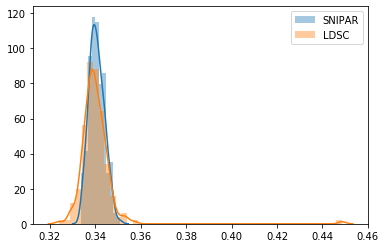

In [15]:
sns.distplot(delvals[..., 2], label = "SNIPAR")
sns.distplot(rg_del.values, label = "LDSC")
plt.legend()

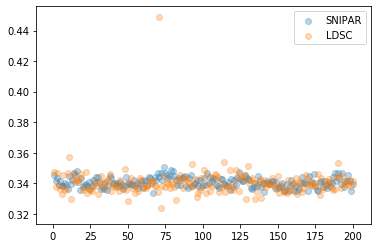

In [16]:
plt.scatter(np.linspace(1, 200, 200), delvals[..., 2], alpha = 0.3, label = "SNIPAR")
plt.scatter(np.linspace(1, 200, 200),rg_del.values, alpha = 0.3, label = "LDSC")
plt.legend()

In [18]:
print(f"SD of SNIPAR Delete vals: {np.std(delvals[..., 2])}")
print(f"SD of LDSC Delete vals: {np.std(rg_del.values)}")

SD of SNIPAR Delete vals: 0.0032788661318404405
SD of LDSC Delete vals: 0.009051502129932507
